In [1047]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
%config InlineBackend.figure_format = 'svg'

In [1048]:
csv_path = '././shampoo.csv'
train = pd.read_csv(csv_path)
train.info()
print(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   36 non-null     object 
 1   Sales   36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 704.0+ bytes
  Month  Sales
0  1-01  266.0
1  1-02  145.9
2  1-03  183.1
3  1-04  119.3
4  1-05  180.3


In [1049]:
import string 
def tod(x):
    year = str(x).split('-')[0]
    month = str(x).split('-')[1]

    year = int(year) + 1900
    month = int(month)
    return str(year) + '-' + str(month)
    
train['Month'] = train['Month'].apply(tod)

train['Month'] = pd.to_datetime(train['Month'], format='%Y-%m')
train.index = train['Month']

In [1050]:
train.drop('Month', axis=1, inplace=True)

In [1051]:
train.head()

,Sales
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3


In [1052]:
def draw_ts(timeseries):
    f = plt.figure(facecolor='white')
    timeseries.plot(color='blue')
    plt.show()

def draw_trend(timeseries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeseries.rolling(window=size).mean()
    # 对size个数据移动平均的方差
    rol_std = timeseries.rolling(window=size).std()

    timeseries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_std.plot(color='black', label='Rolling standard deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

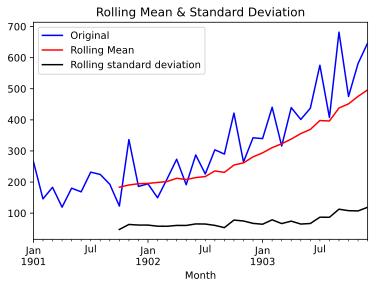

In [1053]:
ts = train['Sales']
draw_trend(ts, 10)

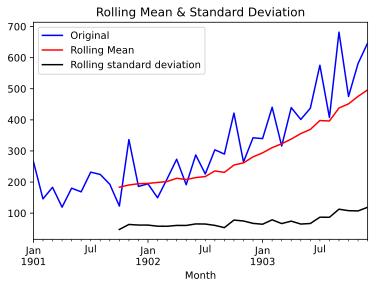

In [1054]:
# ts_log = np.log(ts)
ts_log = ts
draw_trend(ts_log, 10)

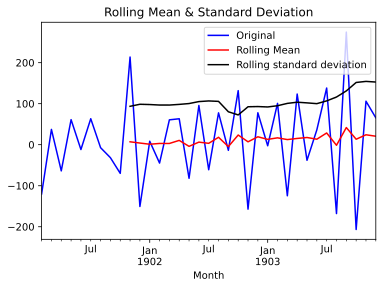

In [1055]:
diff_1 = ts_log.diff(1)
diff_1.dropna(inplace=True)
draw_trend(diff_1, 10)

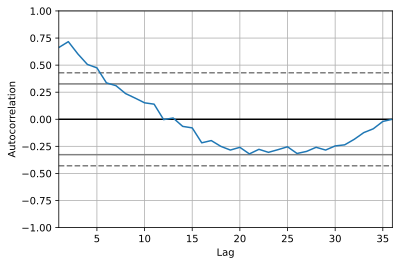

In [1056]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ts_log)
plt.show()
# 运行这个例子，我们可以看到与前10个到12个滞后的正相关，这可能对前5个滞后很重要。模型的AR参数的良好起点可以是5。

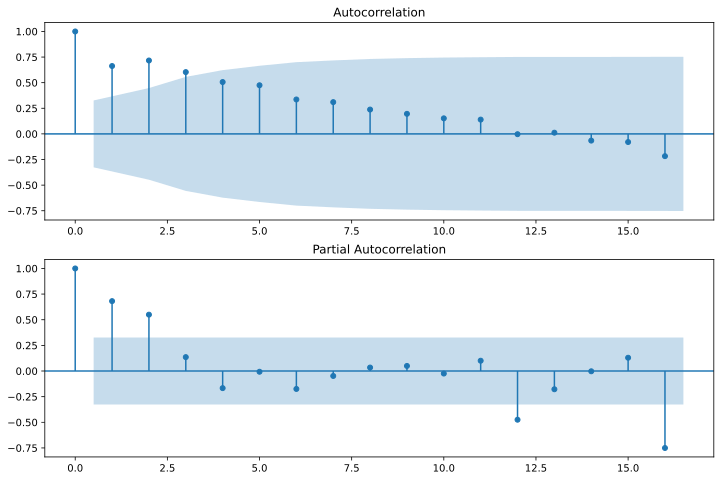

In [1057]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log,lags=16,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log,lags=16,ax=ax2)
plt.show()

# p = 2, d = 1, q = 2

In [1058]:
# model=sm.tsa.statespace.SARIMAX(ts_log,order=(2, 1, 2),seasonal_order=(2,1,2,3))
# model=sm.tsa.statespace.SARIMAX(ts_log,order=(5, 1, 0),seasonal_order=(0,0,0,0))

# 通过观察图中的acf图和pacf图，可以得到：

# * 自相关图显示滞后有三个阶超出了置信边界（第一条线代表起始点，不在滞后范围内）；

# * 偏相关图显示在滞后1至7阶（lags 1,2,…，7）时的偏自相关系数超出了置信边界，从lag 7之后偏自相关系数值缩小至0

# 则有以下模型可以供选择：

# 1. ARMA(0,1)模型：即自相关图在滞后1阶之后缩小为0，且偏自相关缩小至0，则是一个阶数q=1的移动平均模型；

# 2. ARMA(7,0)模型：即偏自相关图在滞后7阶之后缩小为0，且自相关缩小至0，则是一个阶层p=7的自回归模型；

# 3. ARMA(7,1)模型：即使得自相关和偏自相关都缩小至零。则是一个混合模型。
model=sm.tsa.statespace.SARIMAX(ts_log,order=(4, 2, 1),seasonal_order=(0,0,0,0))
results=model.fit()

d:\11516\usual\anaconda\envs\pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
d:\11516\usual\anaconda\envs\pred\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
d:\11516\usual\anaconda\envs\pred\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


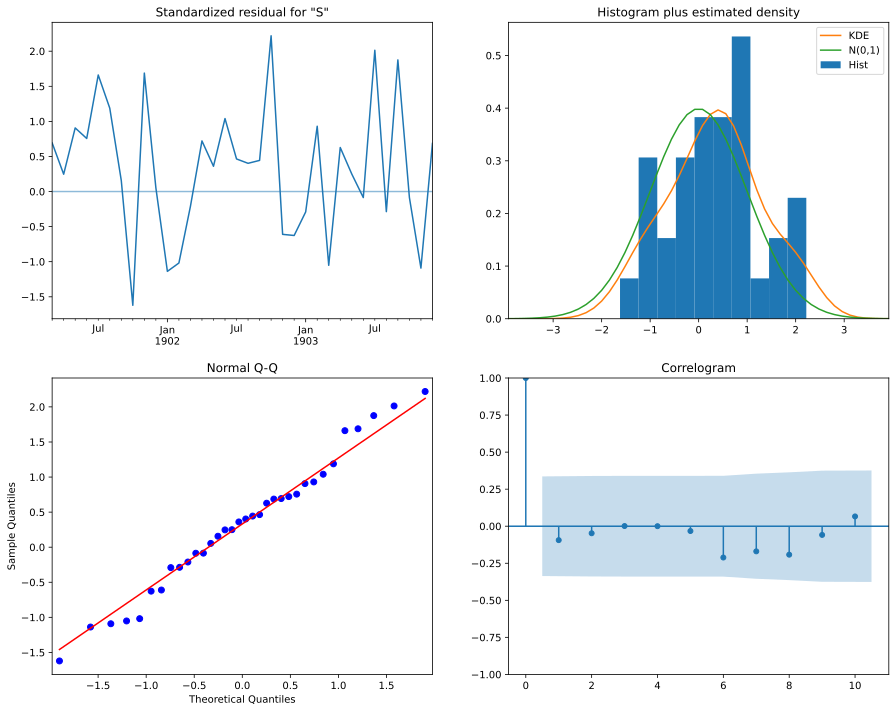

In [1059]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [1060]:
predict_ts = results.predict()
predict_ts_af = results.predict(start=pd.to_datetime('1903-01-01'), dynamic=True, full_results=True)
predict_ts_forecat = results.forecast(12)

In [1061]:
# log_recover = np.exp(predict_ts)
log_recover = predict_ts
log_recover.dropna(inplace=True)

In [1062]:
testsize = 36
log_recover = log_recover[-testsize:]
ts = ts[log_recover.index]

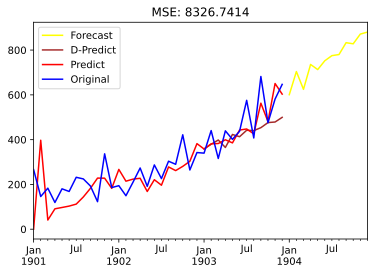

In [1063]:
predict_ts_forecat.plot(color='yellow', label='Forecast')
predict_ts_af.plot(color='brown', label='D-Predict')
log_recover.plot(color='red', label = 'Predict')
ts.plot(color='blue', label='Original')
plt.legend(loc='best')
plt.title('MSE: %.4f'% mean_squared_error(log_recover,ts))
plt.show()